# Systèmes P2P: Simuler Chord

## Fabien Mathieu

### 2018-2019

# Jupyter NoteBooks

Si vous n'avez jamais utilisé de Notebooks, Google est votre ami.

Au cas où, j'ai quelques tutos sur ma page Web.
- https://github.com/balouf/INF674/blob/master/00-Python.ipynb
- https://github.com/balouf/JupTricks/blob/master/PythonGuide.ipynb
- https://github.com/balouf/JupTricks/blob/master/NoteBookGuide.ipynb

Les deux premiers Notebooks sont très similaires.

Mes petites habitudes : d'abord charger numpy and matplotlib, pprint, ensuite discuter.

In [1]:
%pylab inline
from pprint import pprint

Populating the interactive namespace from numpy and matplotlib


J'aime bien que mes *Out*s soient centrés.

In [2]:
%%HTML
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> 


# But du jeu

L'objectif de cet exercice est de simuler une table de hachage distribuée utilisant Chord. *Simuler*, ça veut dire qu'on ne va pas aller au *prototype*, mais se contenter de regarder les mécanismes intéressants dans le cadre d'une DHT: construire les tables de routage, les insertions, etc...

Concrètement, on va joyeusement ignorer tous les problèmes liés à l'implémentation réseau proprement dite (lancer des clients indépendants dans des VM, gérer les connexions réseaux, ...) et tout faire tourner en centralisé en supposant que les primitives existent, et en essayant de ne pas faire appel à des primitives que les pairs ne peuvent pas implanter. Ça sera plus clair ci-dessous. On va également faire l'impasse sur toutes les optimisations mémoires. De toute façon, c'est du Python.

**Remarque:** Normalement, à l'issu de cet exo, vous aurez toutes les billes pour faire une implém' complète si vous maitrisez les aspects classiques de programmation (faire un client, ouvrir une connexion réseau...).

Nous allons reproduire l'exemple de table donné dans le cours.

Les deux cellules ci-dessous servent juste à afficher l'anneau Chord. Si vous n'avez pas installé $\LaTeX$, TikZ et la *magic* TikZ, ne les évaluer pas, ça va planter !

In [3]:
import tikzmagic

In [4]:
%load_ext tikzmagic

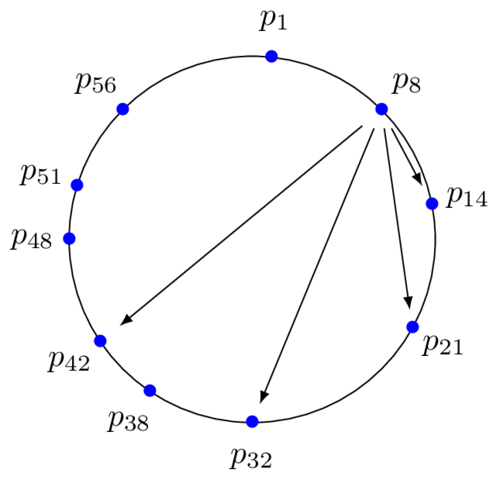

In [5]:
%%tikz --size 500,500
\draw (0,0) circle (2) ;
\foreach \n/\a in {1/84,8/45,14/11,21/331,32/270,38/236,42/214,48/180,51/163,56/135}
{\node[blue] (\n) at (\a:2) {$\bullet$} ;
\node (p\n) at (\a:2.4) {$p_{\n}$} ;}
\draw[->,>=latex] (8) edge (14) edge (21) edge (32) edge (42);

Pour simplifier, on identifiera un pair et sa clé. En particulier, si vous connaissez la clé d'un pair, vous pouvez le contacter. Dans la vraie vie, il faut bien sûr avoir aussi une adresse IP réelle ou quelque chose dans le genre. Par exemple, $p_{38}$ est représenté par quelque chose comme ("p38", 38, Addresse_de_P38, autres_infos). Pour l'exo, 38 fera l'affaire.

# Construction centralisée

Pour commencer, on va supposer que notre DHT est déjà peuplée et fonctionnelle.

In [6]:
Nmax = 64
peer_set = array([1, 8, 14, 21, 32, 38, 42, 48, 51, 56])

Remarque : j'ai utilisé (un peu par flemme) un type *array* pour stocker la liste des pairs, mais si vous préférez autre chose...

### Question 1

Écrire une fonction successeur qui renvoie le successeur d'une clé, ainsi qu'une fonction prédécesseur.

Attention, on n'essaie pas encore de faire du Chord, il s'agit juste de donner la réponse à partir de la connaissance complète du système.

Typiquement, avec ces fonctions, vous devriez pouvoir écrire :

In [9]:
[successeur(p) for p in [30, 42, 60]]

[32, 48, 1]

In [10]:
[predecesseur(p) for p in [37, 1]]

[32, 56]

Remarque : en étant malin, ça peut s'écrire très vite.

**Réponse :**

### Question 2

Faire une structure associant à chaque pair son successeur, son prédécesseur et sa finger table

Comme précédemment, vous pouvez utiliser la connaissance complète du système.

In [12]:
routing_tables = make_routing_table(peer_set)
pprint(routing_tables)

{1: [8, 56, {8, 38, 21, 14}],
 8: [14, 1, {32, 42, 21, 14}],
 14: [21, 8, {32, 48, 21}],
 21: [32, 14, {32, 56, 38}],
 32: [38, 21, {1, 42, 51, 38}],
 38: [42, 32, {48, 8, 42, 56}],
 42: [48, 38, {48, 1, 51, 14}],
 48: [51, 42, {56, 1, 51, 21}],
 51: [56, 48, {56, 1, 21, 8}],
 56: [1, 51, {32, 1, 14}]}


**Réponse :**

Vous avez maintenant un système Chord correctement configuré. 

# Faire tourner Chord 

### Question 1

Tester si un pair $i$ est en charge d'une clé $k$. Cette fonction doit s'exécuter du point de vue du pair, i.e. en utilisant les données possédées par $i$ seulement.

In [14]:
i = 1; k = 56
isincharge(i, k)

True

In [15]:
k = 55
isincharge(i, k)

False

**Réponse :**

### Question 2

Écrire une fonction de recherche de clé, qui va renvoyer la route à suivre pour joindre le pair responsable d'une clé.

In [17]:
lookup(8, 54)

[8, 42, 51, 56]

In [18]:
lookup(42, 14)

[42, 1, 8, 14, 21]

In [19]:
lookup(42, 21)

[42, 14, 21, 32]

**Réponse :**

# Construction décentralisée 

Évidemment, avec une table pleine c'est facile. Partons du début, avec un unique pair, 1.

In [20]:
routing_tables = {1: [1, 1, set([])]}

Bon, le routage, c'est pas tout à fait ça.

In [21]:
lookup(1,42)

[1]

### Question 1

À partir d'un pair p et d'un ensemble de pairs, construire une finger table pour p. Remarque: un pair ne devrait jamais se retourver dans sa propre table de routage.

In [23]:
build_finger(15, set([1, 3, 60, 32, 7, 15, 45, 22]))

{22, 32, 60}

**Réponse :**

### Question 2

Écrivez une fonction pour insérer un pair comme vu en cours, en utilisant 1 comme point d'insertion.

**Réponse :**

### Question 3

Insérer les pairs 8, 14, ... dans l'ordre que vous voulez

- Avez-vous une table fonctionnelle ?
- À quel point est-elle complète ?

**Réponse :**

### Question 4

Proposer des solutions pour avoir des tables plus complètes

**Réponse :**

 # Pour aller plus loin 

### Question 1

Gérer le départ propre d'un pair

**Réponse :**

### Question 2

Plus de clés (par exemple 32 bits), plus de pairs (10000)

**Réponse :**

### Question 3

Injecter des clés à gérer. Étudier leur répartition.

**Réponse :**